In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import cv2
from sklearn.model_selection import KFold

TRAIN_FOLDER = "C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/train-jpg"
TEST_FOLDER = "C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/test-jpg"
csv = pd.read_csv("C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/train_classes.csv", delimiter = ",")
test = pd.read_csv("C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/sample_submission.csv", delimiter = ",")
input_size = 128
batch_size = 32
n_folds = 2
input_channels = 3
epoches = 10
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in csv['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

fold_count = 0
final_results = []
print('#############################')
print('   general variables      ')
print('')
print('n_folds: {}'.format(n_folds))
print('epoches: {}'.format(epoches))
print('batch_size: {}'.format(batch_size))
print('Resize input_size: ({},{}) with {} of channels'.format(input_size, input_size, input_channels))

#############################
   general variables      

n_folds: 2
epoches: 10
batch_size: 32
Resize input_size: (128,128) with 3 of channels


#### In the following code we check:
    1) the size of our data (test and training)
    2) what data contain? (dimensions, channels, how many classes?)
    
## Results
    our trainset consist of 40479 images and each Image is 256x256 pixels
    Images are given in RGBA format (Red, Green, Blue, Alpha) given us 4 channels.

Train shape is: (40479, 2)

Test shape is: (61191, 2)

C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/train-jpg/train_16777.jpg
Image shape (X ,Y, Channels): (256, 256, 4)


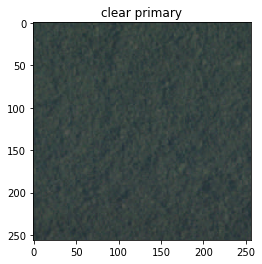

In [63]:
### lets look at the data:
print('Train shape is: {}'.format(csv.shape))
print()
print('Test shape is: {}'.format(test.shape))
print()
# add < label format >
sample = csv.sample()
image_name = sample.image_name.values[0]
path="C:/Users/dordo/עבודות_אוניברסיטה/סדנה_בלמידה_עמוקה/assignment1/planet/planet/train-jpg/"+image_name+'.jpg'
print(path)
img = mpimg.imread(path)
print("Image shape (X ,Y, Channels): {}".format(img.shape))
plt.title(sample.tags.values[0])
plt.imshow(img)
plt.show()

## Information about each image
    Show some random images from our train set
    then dive deep into general details of images
    
## Available augmentation
    In our case we need to be carful with the type of augmentation we process our data with.
    We can't use any augmentation that might lose information as we might lose a road\water stream
    or any other small detail from our image.
    For that reason we decided to use rotations and flips as they preserve the image information and label.

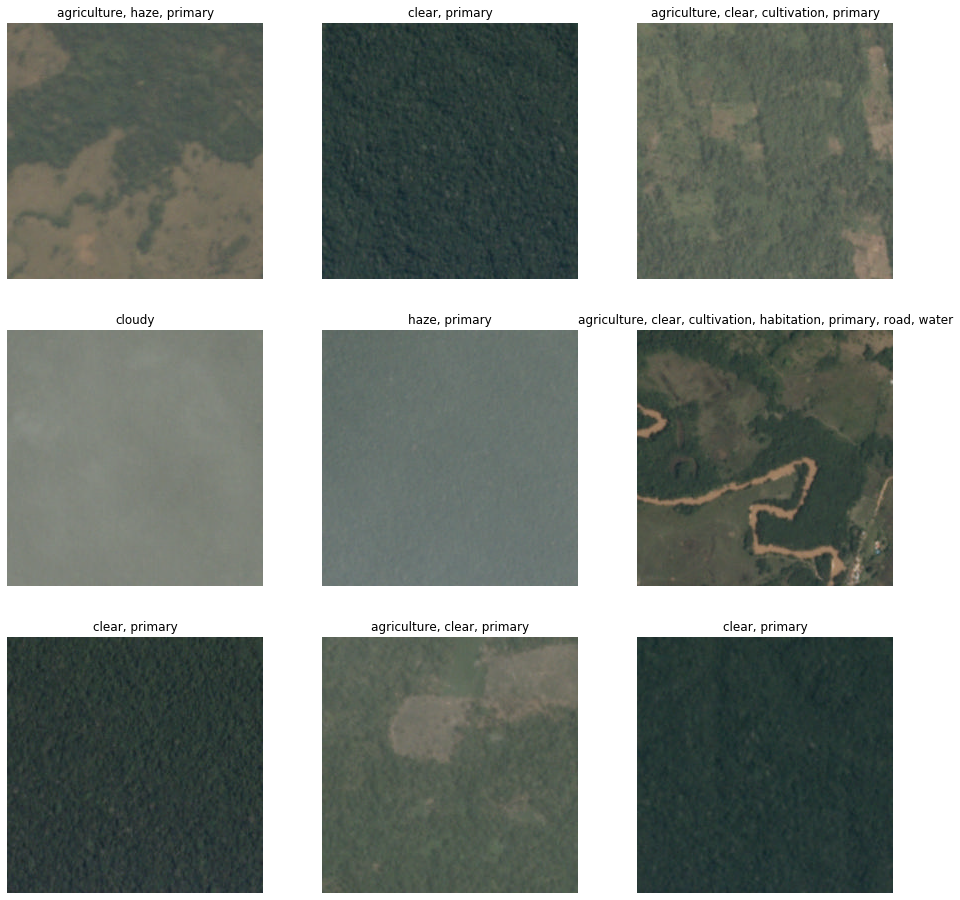

In [64]:
def plot_multiple_imgs(df, path, nrow=2, ncol=2, figsize=(13,7), preds=None, skip=0):
    random_samples = df.sample(nrow * ncol)
    image_name = list(random_samples.image_name)
    image_labels = list(random_samples.tags)
    X = []
    fig=plt.figure(figsize=figsize)
    for i in range(nrow*ncol):
        X.append(mpimg.imread(path+'/'+image_name[i]+'.jpg'))
    for i in range(1, ncol*nrow + 1):
        img = X[i - 1]
        fig.add_subplot(nrow, ncol, i)
        plt.title(", ".join(image_labels[i - 1].split(' ')))
        plt.imshow(img)
        plt.axis("off")
    plt.show()

plot_multiple_imgs(csv, TRAIN_FOLDER,3,3,(16,16))

# Balance of our data
    First we can count the apperance for each label and thus finding all unique labels in the df
    Then We can create an histogram of our data to see how different labels are spread across it.
# Results
    We can easily see the unbalanced nature of our data, with over 35K pictures from our 41K train jpgs
    are labeled primary\clear.
    A point to consider is giving less frequent labels more weight or extra augmentation in order to help
    our model classifying them.

There are 17 unique labels including {'slash_burn', 'cultivation', 'water', 'selective_logging', 'haze', 'clear', 'agriculture', 'cloudy', 'road', 'bare_ground', 'primary', 'partly_cloudy', 'blooming', 'blow_down', 'artisinal_mine', 'conventional_mine', 'habitation'}


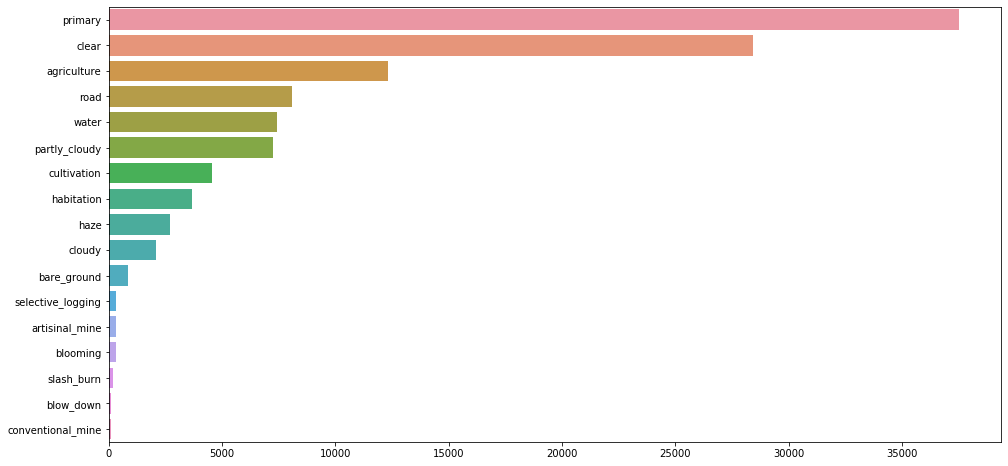

In [65]:
labels_list = list()
for tags in csv['tags'].values:
    for tag in tags.split(' '):
        labels_list.append(tag)

labels_set = set(labels_list)
print("There are {} unique labels including {}".format(len(labels_set), labels_set))

labels_s = pd.Series(labels_list).value_counts()
weaker_labels = list(labels_s[len(labels_s) - 5:].keys())
# Histogram of label instances
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()

# available benchmarks

We've found a lot of benchmarks across kaggle competion notebooks and most the noticeable ones are:
###### LB refer to LeaderBoard 
### Kaggle benchmarks
    1) ResNet50 with TTA LB ~0.93
    2) Keras VGG19 LB ~0.93028
    3) conv networks LB~ 0.87

# Models
    At first we will create a simple model consist of a few conv layers and some maxpooling.
    The simple model will offer us an easy way to assess data and it's behaviour.
    
### Metrics
    Before training our model we will define a few basic metrics including the ones used in the competion itself.
    
### Callbacks
    Along with the metrics we will define a few basic callbacks to make the process easier and more efficient.
    Among the callbacks we will use:
    1) EarlyStopping - Inorder to prevent redundant epoches and reduce the chance of overfitting.
    2) ReduceLROnPlateau - by reducing the learning rate of our model we help it to converge.
    3) ModelCheckpoint - Will enable us to run test and results analysis without training the model again. 

In [66]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D , UpSampling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import fbeta_score
from sklearn.utils import class_weight


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def f2_score(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def f4_score(y_true, y_pred, threshold_shift=0):
    beta = 4

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
            ModelCheckpoint(filepath='weights/best_weights.fold_' + str(fold_count) + '.hdf5',
             save_best_only=True,
             save_weights_only=True)]

metrices = [f2_score, f4_score]

## Model choices
    We face multilabel classification problem with 17 possible classes, in order to get more then 1 label
    as an output we use "Sigmoid" function at our output level.
    Sigmoid will result in a vector the size of 17 with values between [0, 1].

In [67]:
def get_weights(df):
    labels_list = list()
    for tags in df['tags'].values:
        for tag in tags.split(' '):
            labels_list.append(tag)
    labels_set = set(labels_list)
    labels_s = pd.Series(labels_list).value_counts()
    weights = class_weight.compute_class_weight('balanced',
                                                classes=list(label_map),
                                                y=labels_list)
    weights_dict = {}
    index = 0
    for value in list(weights):
        weights_dict[index] = value
        index += 1
    return weights_dict

In [68]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
            ModelCheckpoint(filepath='weights/best_weights.fold_' + str(fold_count) + '.hdf5',
             save_best_only=True,
             save_weights_only=True)]


def simple_model(improvements = False):
    inp = Input(shape = (input_size,input_size,3))
    if improvements:
        x = BatchNormalization()(inp)
        x = UpSampling2D()(x)
    x = Conv2D(64, (4, 4))(inp)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(64, (4, 4))(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Flatten()(x)
    if improvements:
        x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    output = Dense(17, activation = 'sigmoid')(x)
    opt = Adam(lr=1e-4)
    model = Model(inp,output)
    model.compile(optimizer = opt,loss = "binary_crossentropy",metrics = metrices)
    return model



def inceptionv3_model():
    base_model = InceptionV3(include_top=False,
                       weights='imagenet',
                       input_shape=(input_size, input_size, input_channels))

    model = Sequential()
    # Batchnorm input
    model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))
    # Base model
    model.add(base_model)
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid',bias_regularizer=l2(0.01), kernel_regularizer=l2(0.01), activity_regularizer=l1(0.001)))

    opt = Adam(lr=1e-4)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=metrices)
    return model

### Data generators and Augmentation

We define a simple function to handle transformation, each picture goes through
a random augmentation.

Define basic generators for train,valid and test.
Generators handle iamge pulling, resizing, augmenting and translate
labels into a binary vector.

In [75]:
import os
def get_upsampled_df(path):   
    from sklearn.utils import resample
    df = pd.read_csv(path, delimiter = ",")
    index = []
    for tags in df['tags'].values:
        found = False
        for tag in tags.split(' '):
            if tag in weaker_labels:
                found = True
                break
        index.append(found)

    majority = df[[not value for value in index]]
    minority = df[index]

    df_minority_upsampled = resample(minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=5000,    # to match majority class
                                     random_state=123)
    df_upsampled = pd.concat([majority, df_minority_upsampled])
    return df_upsampled

def transformations(src, choice):
    if choice == 0:
        # Rotate 90
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    if choice == 1:
        # Rotate 90 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    if choice == 2:
        # Rotate 180
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
    if choice == 3:
        # Rotate 180 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
        src = cv2.flip(src, flipCode=1)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
    if choice == 5:
        # Rotate 90 counter-clockwise and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    return src

def train_generator(augmentation = False, improvements = False):
    while True:
        for start in range(0, len(df_train), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_train))
            df_train_batch = df_train[start:end]
            for f, tags in df_train_batch.values:
                img = cv2.imread(TRAIN_FOLDER+'/'+f+'.jpg')
                img = cv2.resize(img, (input_size, input_size))
                targets = np.zeros(17)
                is_weak = False
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
#                    if t in weaker_labels:
#                        is_weak = True
                x_batch.append(img)
                y_batch.append(targets)
                if improvements:
                    img = transformations(img, np.random.randint(6))
                    x_batch.append(img)
                    y_batch.append(targets)
#                elif improvements and is_weak:
#                    for i in range(6):
#                        img = transformations(img, i)                        
#                        x_batch.append(img)
#                        y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch


def valid_generator(augmentation = False, improvements = False):
    while True:
        for start in range(0, len(df_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_valid))
            df_valid_batch = df_valid[start:end]
            for f, tags in df_valid_batch.values:
                img = cv2.imread(TRAIN_FOLDER+'/'+f+'.jpg')
                img = cv2.resize(img, (input_size, input_size))
                targets = np.zeros(17)
                is_weak = False
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
                    if t in weaker_labels:
                        is_weak = True
                x_batch.append(img)
                y_batch.append(targets)
                if augmentation and not improvements:
                    img = transformations(img, np.random.randint(6))
                elif improvements and is_weak:
                    for i in range(6):
                        img = transformations(img, i)                        
                        x_batch.append(img)
                        y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

def test_generator():
    while True:
        for start in range(0, len(test), batch_size):
            x_batch = []
            end = min(start + batch_size, len(df_test_data))
            df_test_batch = df_test_data[start:end]
            for f, tags in df_test_batch.values:
                img = cv2.imread(TEST_FOLDER+'/'+f+'.jpg')
                img = cv2.resize(img, (input_size, input_size))
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32)
            yield x_batch

# Train our simple model
    We want to see our simple model perform  without any augmentation or data manipulation.
        Simple model LB ~ 0.87479
        Simple model + Improvements LB ~ 0.88865

In [76]:
fold_count = 0
for train_index, valid_index in kf.split(csv):
    fold_count += 1
    print('-------------------------------------------------------')
    print('Fold ', fold_count)

    # take train and valid sets acording to k-fold
    df_train = csv.iloc[train_index]
    df_valid = csv.iloc[valid_index]
    df_test_data = test

    improvements = False
    model = simple_model(improvements)
    model.fit(x = train_generator(improvements),
                    validation_data=valid_generator(),
                    callbacks = callbacks,
                    steps_per_epoch=(len(df_train) // batch_size) + 1,
                    validation_steps=(len(df_valid) // batch_size) + 1,
                    verbose = 2,
                    epochs=epoches)
    predictions = model.predict_generator(test_generator(),
                                                 steps=((len(df_test_data) // batch_size) + 1),
                                                 verbose=2)
    final_results.append(predictions)

-------------------------------------------------------
Fold  1
(256, 256, 4)
Epoch 1/10


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
results_p = [sum(x)/n_folds for x in zip(*final_results)]
for index, row in test.iterrows():
    prediction = []
    for i in range(17):
        value = results_p[index][i]
        if(value > 0.2):
            prediction.append(inv_label_map[i])
    row['tags'] = " ".join(prediction)
test.to_csv('planet/simple_no_imprv.csv', index=False)

# Improvement suggestions
    1) Added - dropout in order to Prevent Overfitting. 
    2) Added - Upsampling.
    3) Added - Use of weights for labels with lower occurrence .
    4) Added - augmentation flips and rotations, picked randomly.

In [9]:
upsampled_df = get_upsampled_df('planet2/train_v2.csv')
weights = get_weights(upsampled_df)
fold_count = 0
print(len(upsampled_df))
for train_index, valid_index in kf.split(upsampled_df):
    fold_count += 1
    print('-------------------------------------------------------')
    print('Fold ', fold_count)

    # take train and valid sets acording to k-fold
    df_train = upsampled_df.iloc[train_index]
    df_valid = upsampled_df.iloc[valid_index]
    df_test_data = test

    improvements = True
    model = simple_model(improvements)
    model.fit(x = train_generator(improvements),
                    validation_data=valid_generator(),
                    callbacks = callbacks,
                    steps_per_epoch=(len(df_train) // batch_size) + 1,
                    validation_steps=(len(df_valid) // batch_size) + 1,
                    verbose = 1,
                    class_weight = weights,
                    epochs=epoches)
    predictions = model.predict_generator(test_generator(),
                                                 steps=((len(df_test_data) // batch_size) + 1),
                                                 verbose=2)
    final_results.append(predictions)

44410
-------------------------------------------------------
Fold  1
Epoch 1/10
694/694 [==============================] - 106s 153ms/step - loss: 0.2458 - f2_score: 0.5468 - f4_score: 0.5226 - val_loss: 0.4065 - val_f2_score: 0.5740 - val_f4_score: 0.5805
Epoch 2/10
694/694 [==============================] - 108s 156ms/step - loss: 0.2006 - f2_score: 0.5923 - f4_score: 0.5685 - val_loss: 0.3951 - val_f2_score: 0.4740 - val_f4_score: 0.4749
Epoch 3/10
694/694 [==============================] - 101s 146ms/step - loss: 0.1845 - f2_score: 0.6355 - f4_score: 0.6127 - val_loss: 0.3500 - val_f2_score: 0.6118 - val_f4_score: 0.6035
Epoch 4/10
102/694 [===>..........................] - ETA: 47s - loss: 0.1722 - f2_score: 0.6607 - f4_score: 0.6385

KeyboardInterrupt: 

In [ ]:
results_p = [sum(x)/n_folds for x in zip(*final_results)]
for index, row in test.iterrows():
    prediction = []
    for i in range(17):
        value = results_p[index][i]
        if(value > 0.2):
            prediction.append(inv_label_map[i])
    row['tags'] = " ".join(prediction)
test.to_csv('planet/simple_with_imprv.csv', index=False)

# Train inceptionv3 model
    We want to see inceptionv3 model perform  without any augmentation or data manipulation.
        Simple model LB ~ #######
        Simple model + Improvements LB ~ ####

In [ ]:
for train_index, valid_index in kf.split(csv):
    fold_count += 1
    print('-------------------------------------------------------')
    print('Fold ', fold_count)

    # take train and valid sets acording to k-fold
    df_train = csv.iloc[train_index]
    df_valid = csv.iloc[valid_index]
    df_test_data = test

    improvements = False
    model = inceptionv3_model()
    model.fit(x = train_generator(improvements),
                    validation_data=valid_generator(),
                    callbacks = callbacks,
                    steps_per_epoch=(len(df_train) // batch_size) + 1,
                    validation_steps=(len(df_valid) // batch_size) + 1,
                    verbose = 1,
                    class_weight = weights,
                    epochs=epoches)
    predictions = model.predict_generator(test_generator(),
                                                 steps=((len(df_test_data) // batch_size) + 1),
                                                 verbose=2)
    final_results.append(predictions)

In [ ]:
results_p = [sum(x)/n_folds for x in zip(*final_results)]
for index, row in test.iterrows():
    prediction = []
    for i in range(17):
        value = results_p[index][i]
        if(value > 0.2):
            prediction.append(inv_label_map[i])
    row['tags'] = " ".join(prediction)
test.to_csv('planet/inception_no_imprv.csv', index=False)

# Run Inceptionv3 with improvements

In [ ]:
upsampled_df = get_upsampled_df('planet2/train_v2.csv')
fold_count = 0
for train_index, valid_index in kf.split(upsampled_df):
    fold_count += 1
    print('-------------------------------------------------------')
    print('Fold ', fold_count)

    # take train and valid sets acording to k-fold
    df_train = upsampled_df.iloc[train_index]
    df_valid = upsampled_df.iloc[valid_index]
    df_test_data = test

    improvements = True
    model = inceptionv3_model()
    model.fit(x = train_generator(improvements),
                    validation_data=valid_generator(),
                    callbacks = callbacks,
                    steps_per_epoch=(len(df_train) // batch_size) + 1,
                    validation_steps=(len(df_valid) // batch_size) + 1,
                    verbose = 1,
                    class_weight = weights,
                    epochs=epoches)
    predictions = model.predict_generator(test_generator(),
                                                 steps=((len(df_test_data) // batch_size) + 1),
                                                 verbose=2)
    final_results.append(predictions)

In [ ]:
results_p = [sum(x)/n_folds for x in zip(*final_results)]
for index, row in test.iterrows():
    prediction = []
    for i in range(17):
        value = results_p[index][i]
        if(value > 0.2):
            prediction.append(inv_label_map[i])
    row['tags'] = " ".join(prediction)
test.to_csv('planet/inception_with_imprv.csv', index=False)

In [ ]:
df_test_data = pd.read_csv('planet2/train_v2.csv', delimiter = ",")
fold_count = 0
def test_generator():
    while True:
        for start in range(0, len(test), batch_size):
            x_batch = []
            end = min(start + batch_size, len(df_test_data))
            df_test_batch = df_test_data[start:end]
            for f, tags in df_test_batch.values:
                img = cv2.imread(TRAIN_FOLDER+'{}.jpg'.format(f))
                img = cv2.resize(img, (input_size, input_size))
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32)
            yield x_batch
            

predictions = model.predict_generator(test_generator(),
                                             steps=((len(df_test_data) // batch_size) + 1),
                                             verbose=1)
prediction_labels = []
for j in range(len(df_test_data)):
    prediction = []
    for i in range(17):
        value = predictions[j][i]
        if(value > 0.5):
            prediction.append(inv_label_map[i])
    prediction_labels.append(prediction)
    predictions[j][ predictions[j] > 0.5] = 1
    predictions[j][ predictions[j] <= 0.5] = 0
    
true_labels = []
true_values = []
for row in df_test_data.tags.values:
    true_labels.append(row.split(' '))
    values = np.zeros(17)
    for t in row.split(' '):
        values[label_map[t]] = 1
    true_values.append(values)    

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import seaborn as sns

def plt_labels_cm(true_labels, prediction_labels, labels):
    mlb = MultiLabelBinarizer()
    cm = multilabel_confusion_matrix(true_labels,
                                     prediction_labels)
    nrow = 5
    ncol = 4
    fig,ax = plt.subplots(nrows=nrow,ncols=4,figsize=(16, 16))
    fig.subplots_adjust(hspace=1, wspace=0.5)
    # Delete extra axes as we only have 17 labels
    fig.delaxes(ax[4][1])
    fig.delaxes(ax[4][2])
    fig.delaxes(ax[4][3])
    for i in range(len(cm)):
        label_name = inv_label_map[i]
        label_acc = round(100 * (cm[i][0][0] + cm[i][1][1]) / len(df_test_data), 2)
        sns.heatmap(cm[i],cmap='Greens',annot=True, fmt='d', ax= ax[i//ncol, i%ncol]); #annot=True to annotate cells
        ax[i//ncol, i%ncol].set_xlabel('Predicted labels')
        ax[i//ncol, i%ncol].set_ylabel('True labels')
        ax[i//ncol, i%ncol].set_title('Label: {}'.format(label_name))
    plt.show()


    print(classification_report(true_labels,prediction_labels, 
                          target_names= labels))

In [ ]:
plt_labels_cm(true_values, predictions, list(label_map.keys()))

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
model.layers.pop()
model.layers.pop()
features = model.predict_generator(train_generator(improvements),
                                                 steps=((len(df_train) // batch_size) + 1),
                                                 verbose=2)
# x, y = train_generator(improvements)
y=[]
for i in len(df_train):
    tags=df_train[i,1]
    targets = np.zeros(17)
    for t in tags.split(' '):
                    targets[label_map[t]] = 1
    y.append(targets)
treeclassifier = tree.DecisionTreeClassifier(criterion='entropy')
treeclassifier.fit(features, y)
test_features = model.predict_generator(test_generator(),
                                                 steps=((len(df_test_data) // batch_size) + 1),
                                                 verbose=1)
y_pred = treeclassifier.predict(test_features)
# svm = LinearSVC()
# multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)
# multilabel_classifier = multilabel_classifier.fit(features, y)
# y_pred = multilabel_classifier.predict(test_generator())
# svclassifier = SVC(kernel='poly', degree=8)
# svclassifier.fit(features, y)
# y_pred = svclassifier.predict(test_generator())


In [ ]:
print(y_pred)